# Introduction

This is an exploration notebook for the credit card customer churn problem.

Data dictionary:
- **CLIENTNUM**: Client number. Unique identifier for the customer holding the account.
- **Attrition_Flag**: Internal event (customer activity) variable - if the account is closed then 1 else 0.
- **Customer_Age**: Demographic variable - Customer's Age in Years
- **Gender**: Demographic variable - M=Male, F=Female
- **Dependent_count**: Demographic variable - Number of dependents
- **Education_Level**: Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)
- **Marital_Status**: Demographic variable - Married, Single, Divorced, Unknown
- **Income_Category**: Demographic variable - Annual Income Category of the account holder (< $40K, $40K - 60K, $60K - $80K, $80K-$120K, > $120K, Unknown)
- **Card_Category**: Product Variable - Type of Card (Blue, Silver, Gold, Platinum)
- **Months_on_book**: Period of relationship with bank
- **Total_Relationship_Count**: Total no. of products held by the customer
- **Months_Inactive_12_mon**: No. of months inactive in the last 12 months
- **Contacts_Count_12_mon**: No. of Contacts in the last 12 months
- **Credit_Limit**: Credit Limit on the Credit Card
- **Total_Revolving_Bal**: Total Revolving Balance on the Credit Card
- **Avg_Open_To_Buy**: Open to Buy Credit Line (Average of last 12 months)
- **Total_Amt_Chng_Q4_Q1**: Change in Transaction Amount (Q4 over Q1)
- **Total_Trans_Amt**: Total Transaction Amount (Last 12 months)
- **Total_Trans_Ct**: Total Transaction Count (Last 12 months)
- **Total_Ct_Chng_Q4_Q1**: Change in Transaction Count (Q4 over Q1)
- **Avg_Utilization_Ratio**: Average Card Utilization Ratio

# Packages

In [1]:
# Basic packages
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt

# Feature Engineering
from scipy.stats import boxcox

# Class balance
from imblearn.over_sampling import SMOTENC

# Sklearn
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

# ML Algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Model evaluation
import shap

import warnings
warnings.filterwarnings("ignore")

# Read CSV

In [2]:
df = pd.read_csv("BankChurners.csv")

# Remove last two columns
df = df.iloc[:,:21]

df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [3]:
# Check for null values
df.isna().sum().any()

False

In [4]:
# Make target binary
df["Attrition_Flag"] = df["Attrition_Flag"].apply(lambda x: 0 if x == 'Existing Customer' else 1)

df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,0,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


# Data split

In [5]:
X = df.loc[:,df.columns != "Attrition_Flag"]

y = df[["Attrition_Flag"]]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 20)

In [7]:
# Remove client id column from train set
X_train = X_train.iloc[:,1:]

X_train.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
2462,37,F,1,High School,Married,$40K - $60K,Blue,25,4,3,4,5865.0,2517,3348.0,1.348,2623,47,1.350,0.429
3643,44,F,3,High School,Married,Unknown,Blue,38,4,6,4,26516.0,1434,25082.0,0.472,3609,76,0.551,0.054
4824,45,F,0,Unknown,Married,$40K - $60K,Blue,30,3,2,4,2759.0,0,2759.0,0.535,2061,47,0.424,0.000
9049,44,F,5,Uneducated,Single,Less than $40K,Blue,36,1,3,1,7742.0,1163,6579.0,0.729,9081,100,0.852,0.150
1334,36,M,3,Graduate,Married,$60K - $80K,Blue,27,4,3,2,12397.0,1001,11396.0,0.756,1888,42,0.448,0.081


In [8]:
X_train.shape

(7088, 19)

# Initial Analysis

## Target

There is a class imbalance in the dataset

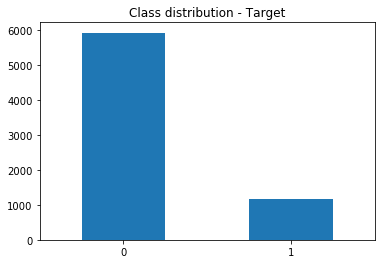

In [9]:
y_train.iloc[:,0].value_counts().plot(kind = "bar", rot = 0, title = "Class distribution - Target")

plt.show()

## Feature type

In [10]:
num_vars = ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
            'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1',
            'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

cat_vars = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']

## Correlation

There seems to be a high correlation between "Avg_Open_To_Buy" and "Credit_Limit" features

In [11]:
corr = X_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
Customer_Age,1.000000,-0.140439,0.785389,-0.013863,0.050617,-0.014647,-0.002483,0.005760,-0.003006,-0.061531,-0.053938,-0.079172,-0.017431,0.002476
Dependent_count,-0.140439,1.000000,-0.118854,-0.046711,-0.017891,-0.032119,0.073893,0.006997,0.073323,-0.033814,0.033703,0.053783,0.010153,-0.031031
Months_on_book,0.785389,-0.118854,1.000000,-0.010586,0.072521,-0.003281,0.006810,0.001576,0.006673,-0.038759,-0.038760,-0.057562,-0.018327,-0.013305
Total_Relationship_Count,-0.013863,-0.046711,-0.010586,1.000000,-0.012013,0.058185,-0.076980,0.011329,-0.078070,0.055672,-0.335210,-0.232857,0.054497,0.070239
Months_Inactive_12_mon,0.050617,-0.017891,0.072521,-0.012013,1.000000,0.032119,-0.031003,-0.053076,-0.026227,-0.047020,-0.043270,-0.049496,-0.050144,-0.009267
Contacts_Count_12_mon,-0.014647,-0.032119,-0.003281,0.058185,0.032119,1.000000,0.007186,-0.051972,0.011894,-0.030604,-0.116021,-0.155786,-0.090193,-0.053907
Credit_Limit,-0.002483,0.073893,0.006810,-0.076980,-0.031003,0.007186,1.000000,0.054552,0.995911,-0.000648,0.175681,0.078248,-0.002214,-0.473337
Total_Revolving_Bal,0.005760,0.006997,0.001576,0.011329,-0.053076,-0.051972,0.054552,1.000000,-0.035879,0.059943,0.063012,0.051252,0.090445,0.623820
Avg_Open_To_Buy,-0.003006,0.073323,0.006673,-0.078070,-0.026227,0.011894,0.995911,-0.035879,1.000000,-0.006072,0.170129,0.073677,-0.010399,-0.530179
Total_Amt_Chng_Q4_Q1,-0.061531,-0.033814,-0.038759,0.055672,-0.047020,-0.030604,-0.000648,0.059943,-0.006072,1.000000,0.039780,0.008470,0.363369,0.047316


In [12]:
# Remove one of them, decided to remove Credit_Limit at first
X_train = X_train.drop(columns = "Credit_Limit")

num_vars.remove("Credit_Limit")

## Feature EDA

### Categorical Features

We can see a high churn ratio amongst Platinum card users

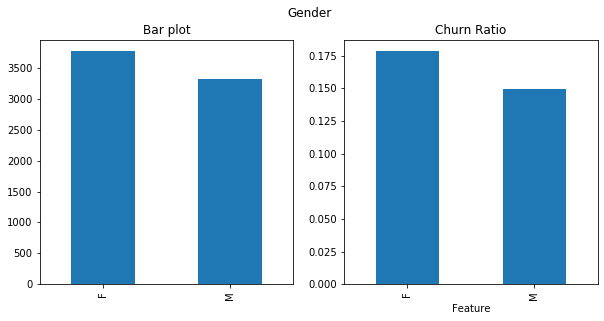

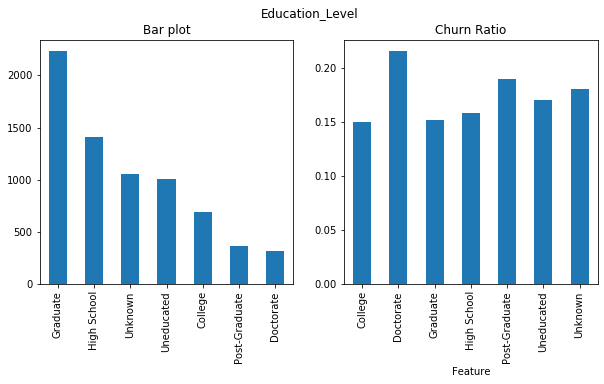

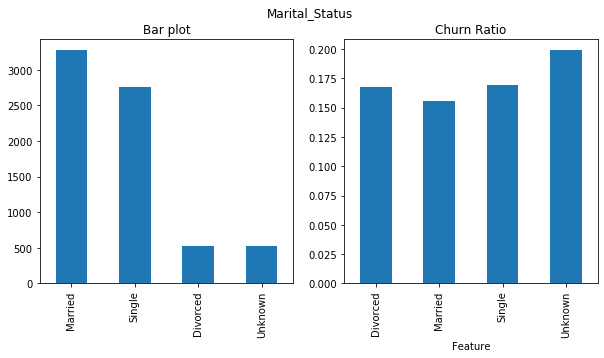

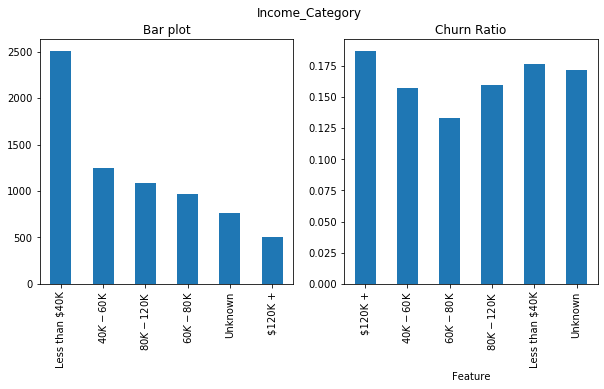

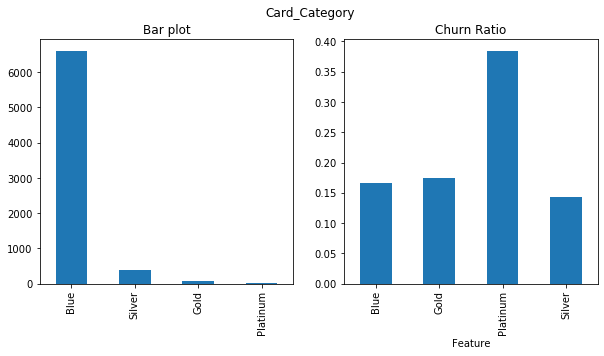

In [13]:
for var in cat_vars:
    # Join training objects into a single dataframe
    feat = pd.DataFrame({"Feature": X_train[var].values, "target": y_train["Attrition_Flag"].values})
    # Aggregate count and sum to calculate ratio
    feat = feat.groupby(by = "Feature").agg(count = pd.NamedAgg(column = "target", aggfunc = "count"),
                                            sum = pd.NamedAgg(column = "target", aggfunc = "sum"))
    feat['churn_ratio'] = feat['sum']/feat['count']
    
    # Create subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [10, 4.5])
    fig.suptitle(var)
    X_train[var].value_counts().plot(kind = 'bar', ax = ax1, title = "Bar plot")
    feat['churn_ratio'].plot(kind = 'bar', ax = ax2, title = "Churn Ratio")
    
    plt.show()

### Numerical Features

For numerical features, we can see some interesting things.
- As expected, clients who holds more products, tend to be more loyal than those with less products. (Total_Relationship_Count)
- Clients who less than two months, also tend to churn less. However, if the clients stays inactive for 3 or 4 months, chances are higher that they will cancel their products. (Months_Inactive_12_mon)
- Also, the more the client has to get in touch with the bank, the more insatified they are. (Contacts_Count_12_mon)
... and so on

As for outliers, Avg_Open_To_Buy, Total_Amt_Chng_Q4_Q1, Total_Trans_Amt and Total_Ct_Chng_Q4_Q1 features must be treated more closel

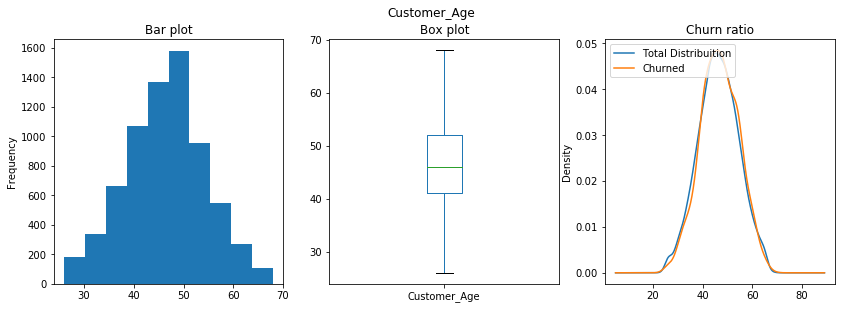

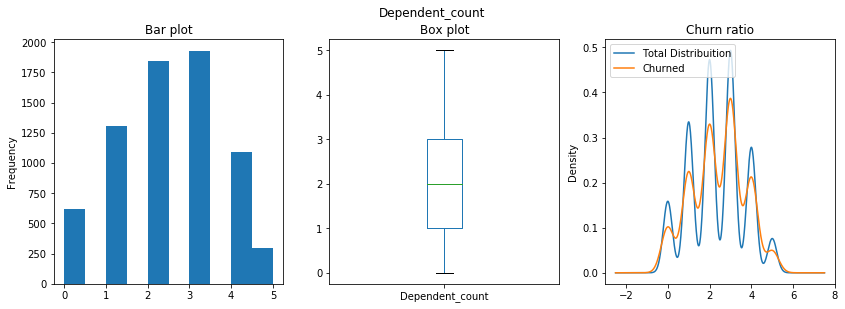

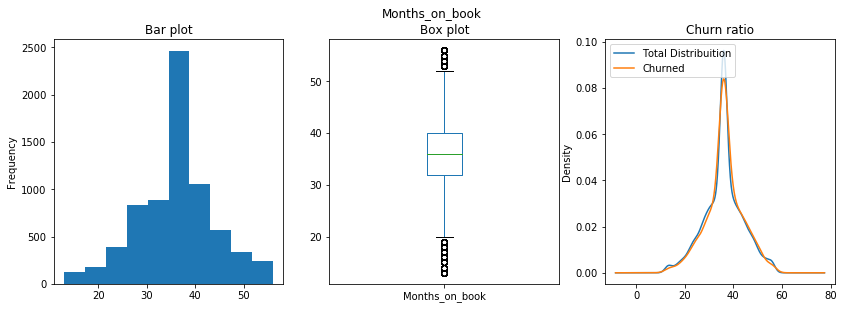

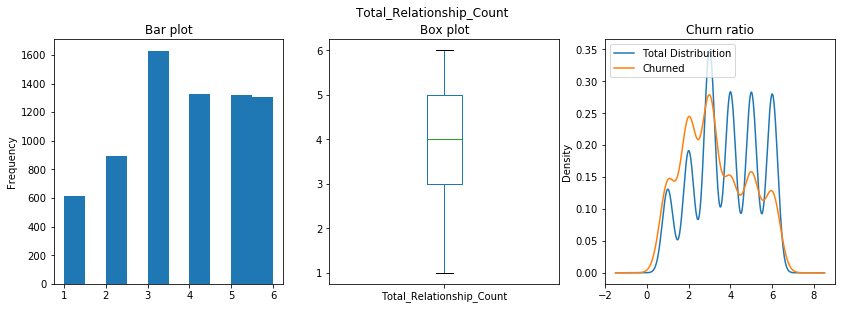

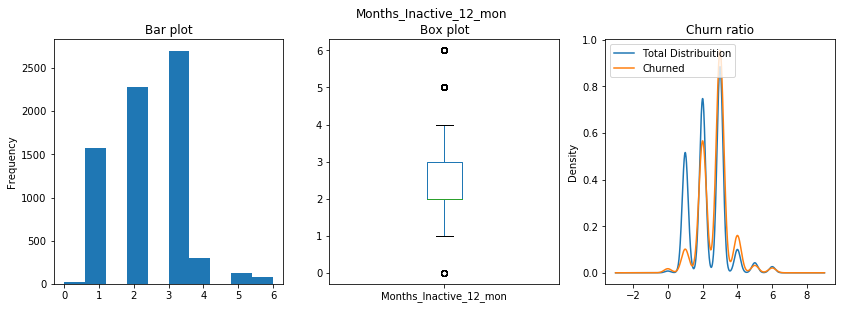

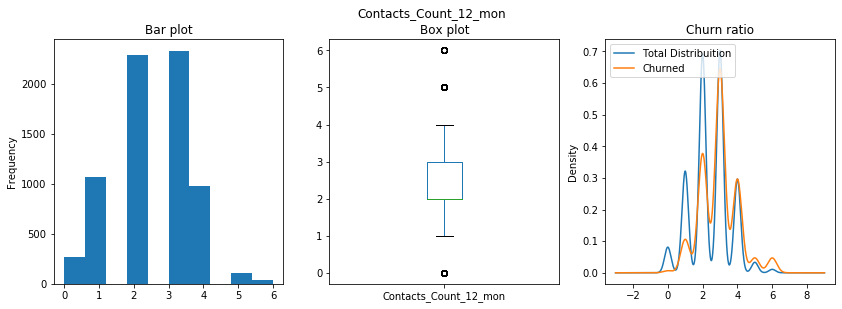

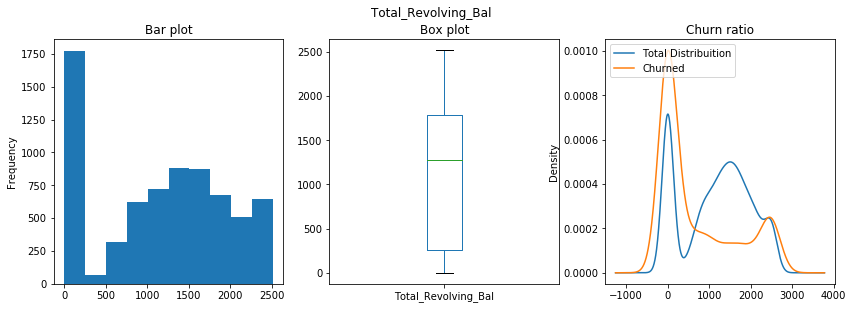

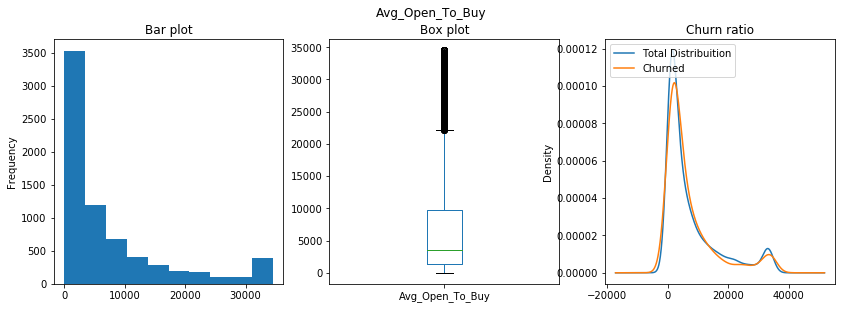

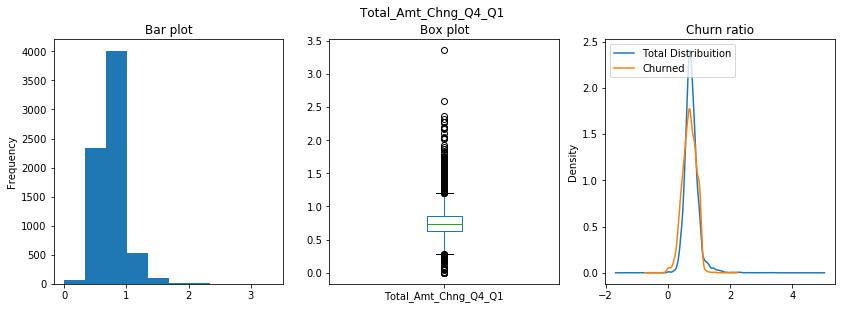

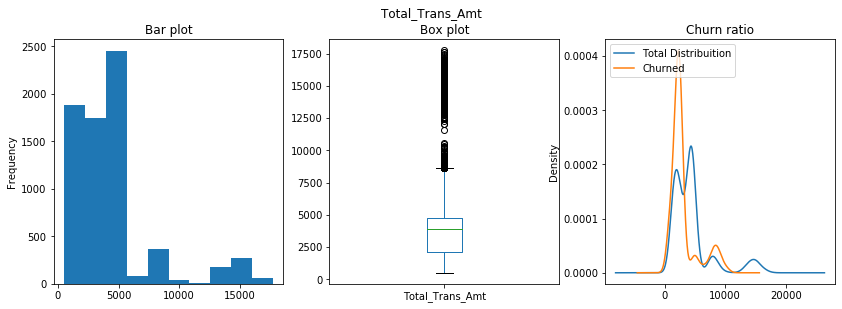

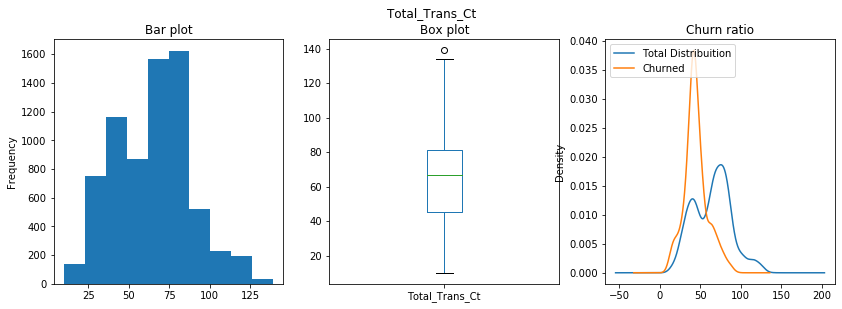

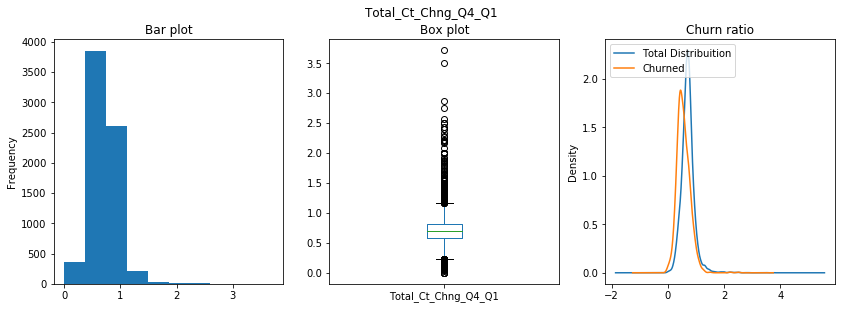

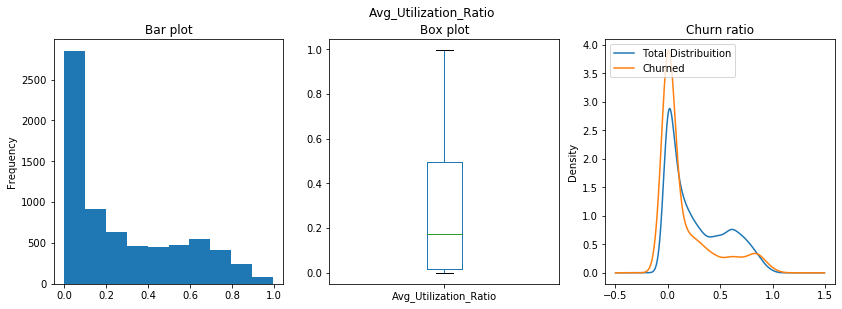

In [14]:
for var in num_vars:
    # Join training objects into a single dataframe
    feat = pd.DataFrame({"Feature": X_train[var].values, "target": y_train["Attrition_Flag"].values})
    
    # Create subplot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = [14, 4.5])
    fig.suptitle(var)
    
    X_train[var].plot(kind = 'hist', ax = ax1, title = "Bar plot")
    
    X_train[var].plot(kind = 'box', ax = ax2, title = "Box plot")
    
    feat["Feature"].plot(kind = 'kde', ax = ax3, title = "Churn ratio", label = "Total Distribuition")
    feat.loc[feat["target"] == 1, "Feature"].plot(kind = 'kde', ax = ax3, label = "Churned")
    ax3.legend(loc = 2)
    
    plt.show()

### Bi-variate analysis

We could plot all features against each other and see how they behave. For simplicity, all plot an example of categorical vs categorical, categorical vs numerical and numerical vs numerical

#### Education_Level vs Income_Category

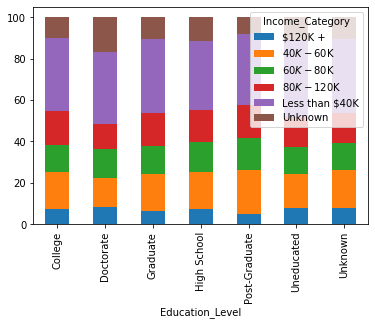

In [15]:
bivariate_cat = X_train[['Education_Level', 'Income_Category', 'Gender']].groupby(by = ['Education_Level', 'Income_Category']).agg(count = pd.NamedAgg(column = 'Gender', aggfunc = 'count'))

bivariate_cat = bivariate_cat.reset_index().pivot(index = 'Education_Level', columns = 'Income_Category', values = 'count')

# Sum row-wise
bivariate_cat['Total'] = bivariate_cat.sum(axis = 1)

# Calculate % by class, except Total
for column in bivariate_cat.columns:
    if column != 'Total':
        bivariate_cat[column] = 100*(bivariate_cat[column]/bivariate_cat['Total'])

# Plot without Total column
bivariate_cat.drop(columns = 'Total').plot.bar(stacked = True)

plt.show()

#### Gender vs Avg_Open_To_Buy

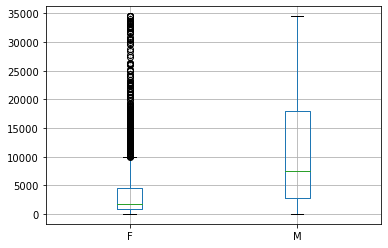

In [16]:
ax = X_train[['Gender', 'Avg_Open_To_Buy']].pivot(columns = 'Gender').boxplot()

# Change x-axis labels
ax.set_xticklabels(['F', 'M'])

plt.show()

#### Total_Trans_Ct vs Avg_Utilization_Ratio

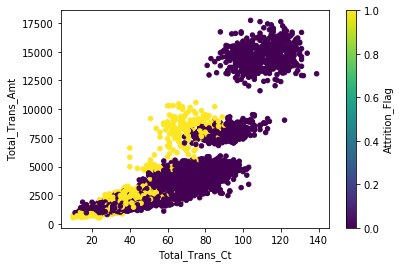

In [17]:
fig, ax = plt.subplots()

X_train[['Total_Trans_Amt', 'Total_Trans_Ct']].join(y_train).plot.scatter(x = 'Total_Trans_Ct', 
                                                                          y = 'Total_Trans_Amt', 
                                                                          c = 'Attrition_Flag',
                                                                          colormap = 'viridis',
                                                                          ax = ax)

plt.show()

# Feature Engineering

## Outlier treatment

The graphs beneath show two different kinds of treatments that could be applied to features in order to adjust outlier values. 

For a better understanding on how boxcox works: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html

For these transformations, if the minimun value of a feature is 0, then we have to add 1 to it (otherwise, log(0) = inf)

### Avg_Open_To_Buy

In [18]:
print("The minimun value of the feature is:", X_train['Avg_Open_To_Buy'].min())

The minimun value of the feature is: 10.0


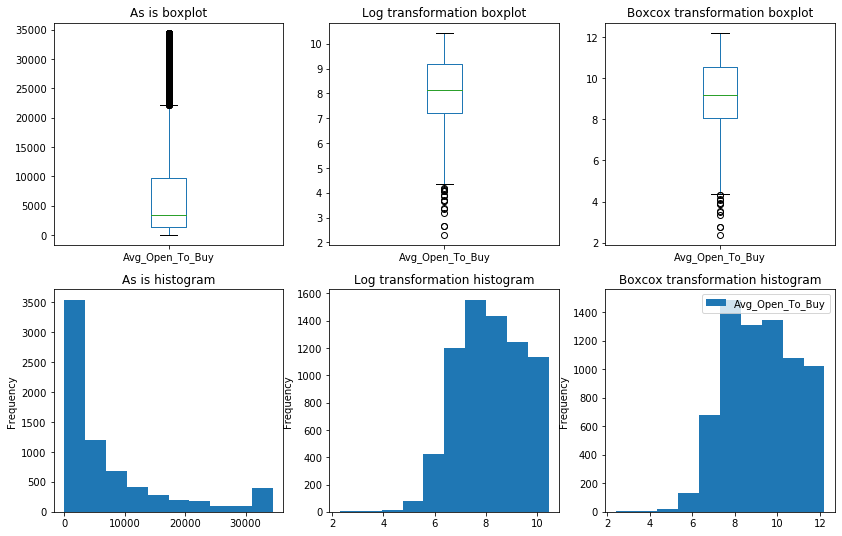

In [19]:
fig, axs = plt.subplots(2, 3, figsize = [14, 9])

X_train['Avg_Open_To_Buy'].plot(kind = 'box', ax = axs[0, 0], title = 'As is boxplot')

X_train['Avg_Open_To_Buy'].apply(np.log).plot(kind = 'box', ax = axs[0, 1], title = 'Log transformation boxplot')

values, lmbda = boxcox(X_train['Avg_Open_To_Buy'])

pd.DataFrame({'Avg_Open_To_Buy': values}).plot(kind = 'box', ax = axs[0, 2], title = 'Boxcox transformation boxplot')

X_train['Avg_Open_To_Buy'].plot(kind = 'hist', ax = axs[1, 0], title = 'As is histogram')

X_train['Avg_Open_To_Buy'].apply(np.log).plot(kind = 'hist', ax = axs[1, 1], title = 'Log transformation histogram')

pd.DataFrame({'Avg_Open_To_Buy': values}).plot(kind = 'hist', ax = axs[1, 2], title = 'Boxcox transformation histogram')

plt.show()

### Total_Trans_Amt

In [20]:
print("The minimun value of the feature is:", X_train['Total_Trans_Amt'].min())

The minimun value of the feature is: 510


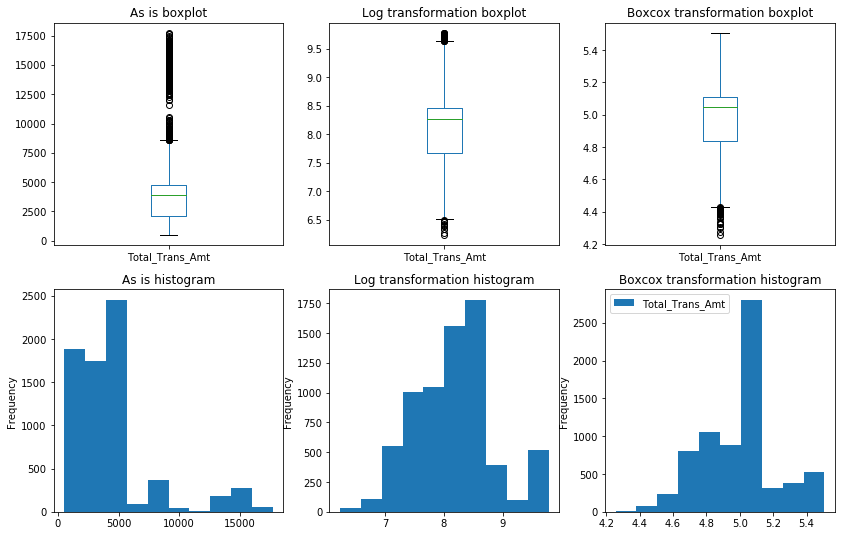

In [21]:
fig, axs = plt.subplots(2, 3, figsize = [14, 9])

X_train['Total_Trans_Amt'].plot(kind = 'box', ax = axs[0, 0], title = 'As is boxplot')

X_train['Total_Trans_Amt'].apply(np.log).plot(kind = 'box', ax = axs[0, 1], title = 'Log transformation boxplot')

values, lmbda = boxcox(X_train['Total_Trans_Amt'])

pd.DataFrame({'Total_Trans_Amt': values}).plot(kind = 'box', ax = axs[0, 2], title = 'Boxcox transformation boxplot')

X_train['Total_Trans_Amt'].plot(kind = 'hist', ax = axs[1, 0], title = 'As is histogram')

X_train['Total_Trans_Amt'].apply(np.log).plot(kind = 'hist', ax = axs[1, 1], title = 'Log transformation histogram')

pd.DataFrame({'Total_Trans_Amt': values}).plot(kind = 'hist', ax = axs[1, 2], title = 'Boxcox transformation histogram')

plt.show()

### Total_Amt_Chng_Q4_Q1

In [22]:
print("The minimun value of the feature is:", X_train['Total_Amt_Chng_Q4_Q1'].min())

The minimun value of the feature is: 0.0


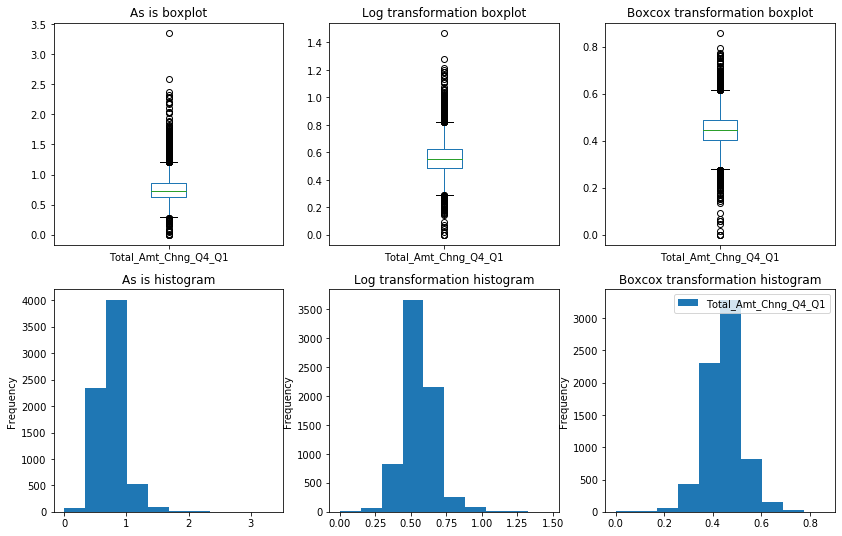

In [23]:
fig, axs = plt.subplots(2, 3, figsize = [14, 9])

X_train['Total_Amt_Chng_Q4_Q1'].plot(kind = 'box', ax = axs[0, 0], title = 'As is boxplot')

X_train['Total_Amt_Chng_Q4_Q1'].apply(lambda x: np.log(x + 1)).plot(kind = 'box', ax = axs[0, 1], title = 'Log transformation boxplot')

values, lmbda = boxcox(X_train['Total_Amt_Chng_Q4_Q1'].apply(lambda x: x + 1))

pd.DataFrame({'Total_Amt_Chng_Q4_Q1': values}).plot(kind = 'box', ax = axs[0, 2], title = 'Boxcox transformation boxplot')

X_train['Total_Amt_Chng_Q4_Q1'].plot(kind = 'hist', ax = axs[1, 0], title = 'As is histogram')

X_train['Total_Amt_Chng_Q4_Q1'].apply(lambda x: np.log(x + 1)).plot(kind = 'hist', ax = axs[1, 1], title = 'Log transformation histogram')

pd.DataFrame({'Total_Amt_Chng_Q4_Q1': values}).plot(kind = 'hist', ax = axs[1, 2], title = 'Boxcox transformation histogram')

plt.show()

### Total_Ct_Chng_Q4_Q1

In [24]:
print("The minimun value of the feature is:", X_train['Total_Ct_Chng_Q4_Q1'].min())

The minimun value of the feature is: 0.0


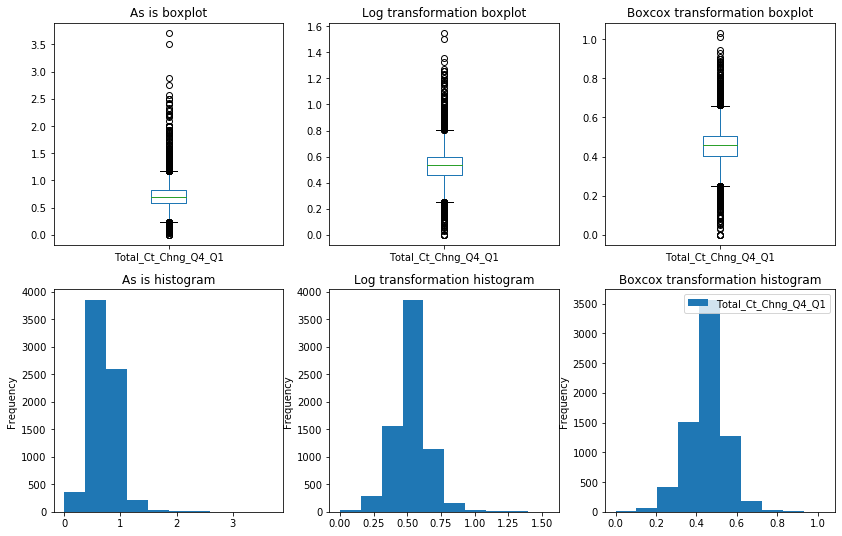

In [25]:
fig, axs = plt.subplots(2, 3, figsize = [14, 9])

X_train['Total_Ct_Chng_Q4_Q1'].plot(kind = 'box', ax = axs[0, 0], title = 'As is boxplot')

X_train['Total_Ct_Chng_Q4_Q1'].apply(lambda x: np.log(x + 1)).plot(kind = 'box', ax = axs[0, 1], title = 'Log transformation boxplot')

values, lmbda = boxcox(X_train['Total_Ct_Chng_Q4_Q1'].apply(lambda x: x + 1))

pd.DataFrame({'Total_Ct_Chng_Q4_Q1': values}).plot(kind = 'box', ax = axs[0, 2], title = 'Boxcox transformation boxplot')

X_train['Total_Ct_Chng_Q4_Q1'].plot(kind = 'hist', ax = axs[1, 0], title = 'As is histogram')

X_train['Total_Ct_Chng_Q4_Q1'].apply(lambda x: np.log(x + 1)).plot(kind = 'hist', ax = axs[1, 1], title = 'Log transformation histogram')

pd.DataFrame({'Total_Ct_Chng_Q4_Q1': values}).plot(kind = 'hist', ax = axs[1, 2], title = 'Boxcox transformation histogram')

plt.show()

We can see that even boxcox could not handle all the outliers. However, in most of them the distribution became much closer to a normal distribution. Therefore, let's use it.

In [26]:
X_train_box = X_train.copy()

# Generate lambda values for features
outlier_vars = ['Avg_Open_To_Buy', 'Total_Trans_Amt', 'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1']

lmbdas_treatment = {}

for var in outlier_vars:
    if (X_train_box[var].min() > 0):
        values, lmbda = boxcox(X_train_box[var])
        X_train_box[var] = values
        lmbdas_treatment[var] = lmbda
    else:
        values, lmbda = boxcox(X_train_box[var].apply(lambda x: x + 1))
        X_train_box[var] = values
        lmbdas_treatment[var] = lmbda

# Pre Processing

## One Hot Encoding Categorical Features

In [27]:
# Create encoder and fit encoder
encoder = OneHotEncoder(drop = 'first', sparse = False)

encoder = encoder.fit(X_train[cat_vars])

# Create new training set
X_train_new = pd.DataFrame(encoder.transform(X_train[cat_vars]), columns = encoder.get_feature_names(cat_vars))

X_train_new = X_train_new.join(X_train[num_vars].reset_index(drop = True))

# Create new training set with boxcox
X_train_box_new = pd.DataFrame(encoder.transform(X_train_box[cat_vars]), columns = encoder.get_feature_names(cat_vars))

X_train_box_new = X_train_box_new.join(X_train_box[num_vars].reset_index(drop = True))

## Data scaling

We have numerical features in all sorts of scales. For distance based algorithms, we need them to be in a compatible scale, so we do not assign a higher weight to a feature just because of its values.

We have two most used option for it: Normalization and Standardization

Normalization: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

Standardization: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

### Normalization

In [28]:
normal_scaler = MinMaxScaler()

normal_scaler = normal_scaler.fit(X_train_new[num_vars])

X_train_normal_new = X_train_new.copy()

X_train_normal_new[num_vars] = normal_scaler.transform(X_train_new[num_vars])

In [29]:
normal_box_scaler = MinMaxScaler()

normal_box_scaler = normal_box_scaler.fit(X_train_box_new[num_vars])

X_train_box_normal_new = X_train_box_new.copy()

X_train_box_normal_new[num_vars] = normal_scaler.transform(X_train_box_new[num_vars])

### Standardization

In [30]:
standard_scaler = StandardScaler()

standard_scaler = standard_scaler.fit(X_train_new[num_vars])

X_train_standard_new = X_train_new.copy()

X_train_standard_new[num_vars] = normal_scaler.transform(X_train_new[num_vars])

In [31]:
standard_box_scaler = StandardScaler()

standard_scaler = standard_scaler.fit(X_train_box_new[num_vars])

X_train_box_standard_new = X_train_box_new.copy()

X_train_box_standard_new[num_vars] = normal_scaler.transform(X_train_box_new[num_vars])

## Balance classes

There are quite a few ways of handling imbalanced datasets
- We can just leave as it is, in such case we should choose a scoring metric accordingly (accuracy would just tell you to choose majority class)
- We can use stratified cross validation, in order to adjust variance during training step
- Undersample majority class
- Oversample minority class
- Generate synthetic data, etc.

Each method has its ups and downs. I'll apply here synthetic data generation to balance class and try to keep it as representative to reality as possible. However, I AM chaging the way the algorithm calculates probabilities, therefore choose carefully whatever approach and plan accordingly.

In [32]:
seed = 100

# Categorical features
new_cat_vars = encoder.get_feature_names(cat_vars)

cat_vars_index = []

for var in encoder.get_feature_names(cat_vars):
    cat_vars_index.append(X_train_new.columns.get_loc(var))

# Create SMOTE object to balance minority class
oversample = SMOTENC(categorical_features = cat_vars_index, random_state = seed)

# Apply SMOTE to training set without any FE
X_train_balanced, y_train_balanced = oversample.fit_resample(X_train_new, y_train)

# Apply SMOTE to training set with normalization
X_train_normal_balanced, y_train_normal_balanced = oversample.fit_resample(X_train_normal_new, y_train)

# Apply SMOTE to training set with standardization
X_train_std_balanced, y_train_std_balanced = oversample.fit_resample(X_train_standard_new, y_train)

# Apply SMOTE to training set with boxcox
X_train_box_balanced, y_train_box_balanced = oversample.fit_resample(X_train_box_new, y_train)

# Apply SMOTE to training set with boxcox and normalization
X_train_box_normal_balanced, y_train_box_normal_balanced = oversample.fit_resample(X_train_box_normal_new, y_train)

# Apply SMOTE to training set with boxcox and standardization
X_train_box_std_balanced, y_train_box_std_balanced = oversample.fit_resample(X_train_box_standard_new, y_train)

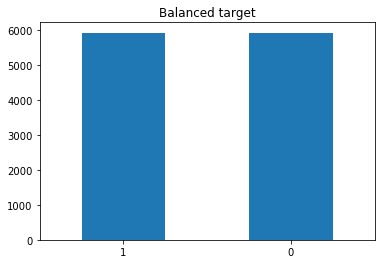

In [33]:
y_train_balanced.iloc[:,0].value_counts().plot(kind = 'bar', rot = 0, title = "Balanced target")

# Comparing performances

## Create models

I'll set max_depth to 4, due to training dataset size. By doing so, we at least try to avoid overfitting the model. Changing learning rate, gamma (for XGBoost), among other parameters could also help avoiding it.

LR w/o FE: 0.886199 (0.013016)
RF w/o FE: 0.956451 (0.006845)
XGB w/o FE: 0.997905 (0.000828)
LR normal: 0.965021 (0.003527)
RF normal: 0.963474 (0.004566)
XGB normal: 0.998377 (0.000558)
LR std: 0.965021 (0.003527)
RF std: 0.963367 (0.004532)
XGB std: 0.998377 (0.000558)
LR boxcox: 0.915948 (0.011910)
RF boxcox: 0.956819 (0.006161)
XGB boxcox: 0.997603 (0.000796)
LR boxcox normal: 0.955962 (0.005350)
RF boxcox normal: 0.959453 (0.004711)
XGB boxcox normal: 0.998150 (0.000688)
LR boxcox standard: 0.955962 (0.005350)
RF boxcox standard: 0.959128 (0.006049)
XGB boxcox standard: 0.998150 (0.000688)


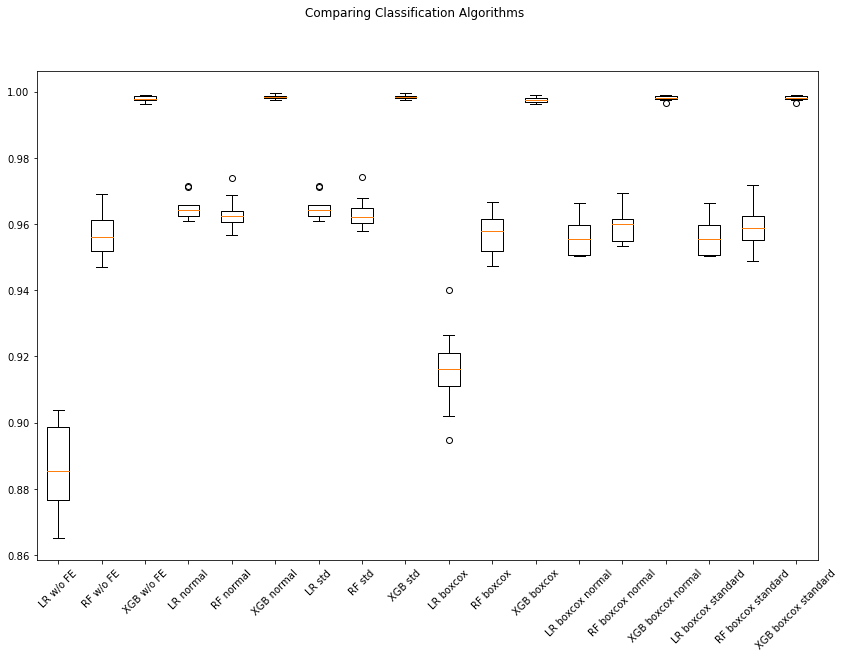

In [34]:
# Definindo os valores para o número de folds
num_folds = 10
scoring = 'roc_auc'
seed = 7

# Preparando a lista de modelos
models = []
models.append(('LR w/o FE', LogisticRegression()))
models.append(('RF w/o FE', RandomForestClassifier(max_depth = 4, criterion = 'entropy')))
models.append(('XGB w/o FE', XGBClassifier(max_depth = 4)))
models.append(('LR normal', LogisticRegression()))
models.append(('RF normal', RandomForestClassifier(max_depth = 4, criterion = 'entropy')))
models.append(('XGB normal', XGBClassifier(max_depth = 4)))
models.append(('LR std', LogisticRegression()))
models.append(('RF std', RandomForestClassifier(max_depth = 4, criterion = 'entropy')))
models.append(('XGB std', XGBClassifier(max_depth = 4)))
models.append(('LR boxcox', LogisticRegression()))
models.append(('RF boxcox', RandomForestClassifier(max_depth = 4, criterion = 'entropy')))
models.append(('XGB boxcox', XGBClassifier(max_depth = 4)))
models.append(('LR boxcox normal', LogisticRegression()))
models.append(('RF boxcox normal', RandomForestClassifier(max_depth = 4, criterion = 'entropy')))
models.append(('XGB boxcox normal', XGBClassifier(max_depth = 4)))
models.append(('LR boxcox standard', LogisticRegression()))
models.append(('RF boxcox standard', RandomForestClassifier(max_depth = 4, criterion = 'entropy')))
models.append(('XGB boxcox standard', XGBClassifier(max_depth = 4)))

# Avaliando cada modelo em um loop
results = []
names = []

for name, model in models:
    # Create KFold validation
    kfold = KFold(n_splits = num_folds, random_state = seed, shuffle = True)
    # Conditions for each treatment
    if ("w/o FE" in name):
        cv_results = cross_val_score(model, 
                                     X_train_balanced, 
                                     y_train_balanced, 
                                     cv = kfold, 
                                     scoring = scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    elif (("boxcox" not in name) & ("normal" in name)):
        cv_results = cross_val_score(model, 
                                     X_train_normal_balanced, 
                                     y_train_normal_balanced, 
                                     cv = kfold, 
                                     scoring = scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    elif (("boxcox" not in name) & ("std" in name)):
        cv_results = cross_val_score(model, 
                                     X_train_std_balanced, 
                                     y_train_std_balanced, 
                                     cv = kfold, 
                                     scoring = scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    elif (("boxcox" in name) & ("normal" in name)):
        cv_results = cross_val_score(model, 
                                     X_train_box_normal_balanced, 
                                     y_train_box_normal_balanced, 
                                     cv = kfold, 
                                     scoring = scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    elif (("boxcox" in name) & ("standard" in name)):
        cv_results = cross_val_score(model, 
                                     X_train_box_std_balanced, 
                                     y_train_box_std_balanced, 
                                     cv = kfold, 
                                     scoring = scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    else: 
        cv_results = cross_val_score(model, 
                                     X_train_box_balanced, 
                                     y_train_box_balanced, 
                                     cv = kfold, 
                                     scoring = scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

# Boxplot to compare algorithms
fig = plt.figure(figsize = [14, 9])
fig.suptitle('Comparing Classification Algorithms')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.xticks(rotation = 45)
ax.set_xticklabels(names)
plt.show()

## Is XGB classifier overfitting?

As the XGB performance were all pretty close, for simplicity of treatment (and deployment later on) I'll use the model with no FE

In [35]:
# Transform train set
X_test_encoded = encoder.transform(X_test[cat_vars])

# Concatenate one hot encoded categorical features with numerical
X_test_new = pd.DataFrame(X_test_encoded, columns = encoder.get_feature_names(cat_vars))

X_test_new = X_test_new.join(X_test[num_vars].reset_index(drop = True))

AUC: 95.00%


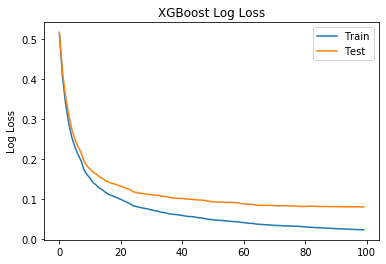

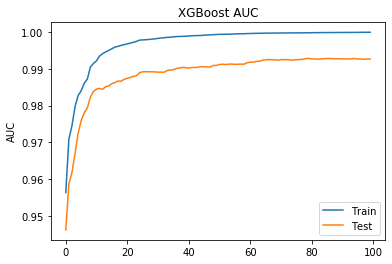

In [36]:
# Create classifier
model = XGBClassifier(max_depth = 4)

# Create eval set with both training and test set
eval_set = [(X_train_balanced, y_train_balanced), (X_test_new, y_test)]

# Fit model 
model.fit(X_train_balanced, y_train_balanced, eval_metric=["auc", "logloss"], eval_set=eval_set, verbose=False)

# Make predictions for test data
y_pred = model.predict(X_test_new)

# Evaluate predictions
auc = roc_auc_score(y_test, y_pred)
print("AUC: %.2f%%" % (auc * 100.0))

# Retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# Plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

# Plot AUC
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

As we can see, log loss and auc gain on both training and test set stay pretty close over training rounds, so there is no evidence of overfitting. On the other hand, as stated previously, this is a small dataset and predictions may get a little off over time.

## Measuring XGBoost Performance on Test set

In [37]:
# Create classifier
xgb = XGBClassifier(max_depth = 4)

# Fit model
xgb = xgb.fit(X_train_balanced, y_train_balanced)

# Make Predictions
y_pred = xgb.predict_proba(X_test_new)[:,1]

AUC: 99.26%
Best threshold value is: 0.18852043


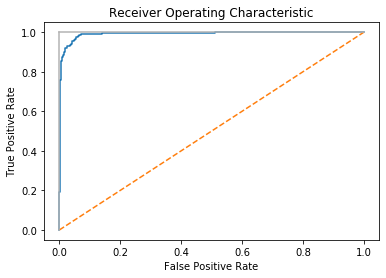

In [38]:
# Create ROC curve variables
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred)

# Print model AUC
print("AUC: %.2f%%" % (roc_auc_score(y_test, y_pred) * 100.0))

# Print best threshold
optimal_idx = np.argmax(true_positive_rate - false_positive_rate)
optimal_threshold = threshold[optimal_idx]
print("Best threshold value is:", optimal_threshold)

# Ploting ROC curves
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

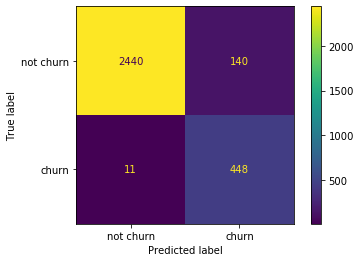

In [39]:
# Transform predictions to round number
y_pred_round = [1 if pred > optimal_threshold else 0 for pred in y_pred]

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_round)

cmd = ConfusionMatrixDisplay(cm, display_labels=['not churn','churn'])
cmd.plot()
plt.show()

## Feature Selection

We could lower model complexity by using only the most suitable features. This can be achieved with lots of techniques.

I'll use mutual information gain as score function. Mutual information gain is a non parametric test, which means it does not make any assumptions on the distribution  of data. Chi-square is another option here, however it does assume the features are normally distributed.

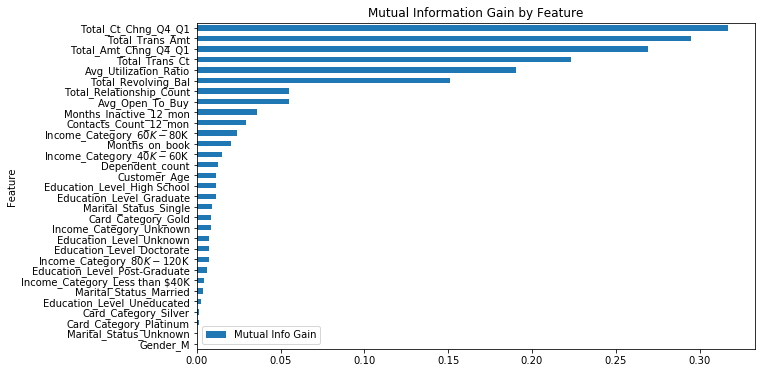

In [40]:
# Mutual info score
info_score = mutual_info_classif(X_train_balanced, y_train_balanced, n_neighbors = 3, random_state = seed)

mutual_info = pd.DataFrame({'Feature': X_train_balanced.columns.values, 'Mutual Info Gain': info_score})

fig, ax = plt.subplots(figsize = [10,6])
mutual_info.sort_values(by = 'Mutual Info Gain').plot.barh(x = 'Feature', y = 'Mutual Info Gain', ax = ax, title = "Mutual Information Gain by Feature")
plt.show()

In [41]:
# Create KBest processor
best_processor = SelectKBest(score_func = mutual_info_classif, k = 12).fit(X_train_balanced, y_train_balanced)

# Transform training set
columns = X_train_balanced.columns.values[best_processor.get_support(indices=True)]

X_train_balanced_fs = pd.DataFrame(best_processor.transform(X_train_balanced), 
                                   columns = columns)

X_train_balanced_fs.head()

,Education_Level_Graduate,Income_Category_$60K - $80K,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0.0,0.0,4.0,3.0,4.0,2517.0,3348.0,1.348,2623.0,47.0,1.350,0.429
1,0.0,0.0,4.0,6.0,4.0,1434.0,25082.0,0.472,3609.0,76.0,0.551,0.054
2,0.0,0.0,3.0,2.0,4.0,0.0,2759.0,0.535,2061.0,47.0,0.424,0.000
3,0.0,0.0,1.0,3.0,1.0,1163.0,6579.0,0.729,9081.0,100.0,0.852,0.150
4,1.0,1.0,4.0,3.0,2.0,1001.0,11396.0,0.756,1888.0,42.0,0.448,0.081


In [42]:
# Transform test set
X_test_new_fs = X_test_new[columns]

X_test_new_fs.head()

,Education_Level_Graduate,Income_Category_$60K - $80K,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,1.0,1.0,4,3,4,0,28701.0,1.165,3516,57,0.727,0.000
1,0.0,0.0,3,3,2,1924,1666.0,0.573,1472,37,0.762,0.536
2,0.0,0.0,5,3,4,0,19995.0,0.650,1879,34,0.700,0.000
3,0.0,1.0,6,4,3,0,2049.0,0.974,2703,54,1.000,0.000
4,0.0,0.0,5,3,5,0,2879.0,1.031,4684,56,0.556,0.000


### Train new model

In [43]:
# Create classifier
xgb = XGBClassifier(max_depth = 4)

# Tuple of sets
#eval_set = [(X_train_balanced, y_train_balanced), (X_test_new, y_test)]

# Fit model
xgb = xgb.fit(X_train_balanced_fs, y_train_balanced)

# Make Predictions
y_pred = xgb.predict_proba(X_test_new_fs)[:,1]

AUC: 99.03%
Best threshold value is: 0.29983824


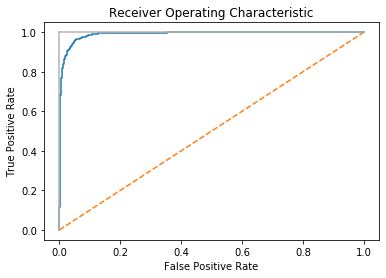

In [44]:
# Create ROC curve variables
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred)

# Print model AUC
print("AUC: %.2f%%" % (roc_auc_score(y_test, y_pred) * 100.0))

# Print best threshold
optimal_idx = np.argmax(true_positive_rate - false_positive_rate)
optimal_threshold = threshold[optimal_idx]
print("Best threshold value is:", optimal_threshold)

# Ploting ROC curves
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

More performatic model in every way!

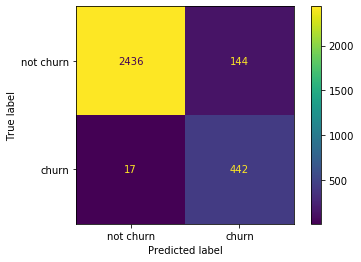

In [45]:
# Transform predictions to round number
y_pred_round = [1 if pred > optimal_threshold else 0 for pred in y_pred]

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_round)

cmd = ConfusionMatrixDisplay(cm, display_labels=['not churn','churn'])
cmd.plot()

# Model evaluation

There should be a step of hyperparameters tuning before evaluating the final model, but the performance is so high alreay that I don't think it is necessary in this case.

So, let's jump to understanding why the classifier gave the results it did. To do so, SHAP package is one of the best.

To better understand SHAP: https://github.com/slundberg/shap and https://shap.readthedocs.io/en/latest/index.html

## Final model

Using model with all features to see how changes in each of them impact the outcome

In [46]:
# Create classifier
xgb_final = XGBClassifier(max_depth = 4)

# Fit model
xgb_final = xgb_final.fit(X_train_balanced, y_train_balanced)

# Make Predictions
y_pred = xgb_final.predict_proba(X_test_new)[:,1]

## How feature values impact classification?

Business person: Why is this person being rated as such? 
Data scientist: Historically, people who buy and spend approximately 1.35 times more on Q4 compared to Q1 are less prone to churning


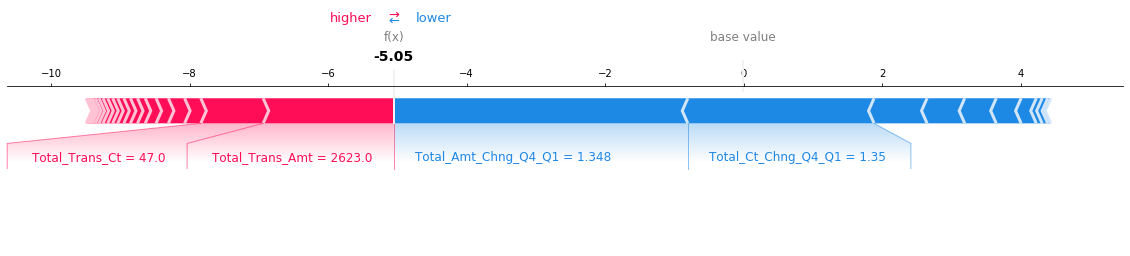

In [47]:
# Create explainer object
explainer = shap.TreeExplainer(xgb_final)
shap_values = explainer.shap_values(X_train_balanced)

print("Business person: Why is this person being rated as such? \nData scientist: Historically, people who buy and spend approximately 1.35 times more on Q4 compared to Q1 are less prone to churning")

# Visualize prediction
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_balanced.iloc[0,:], matplotlib=True)

Business person: Cool! Ok, so... what else affects the output in general? 
Data scientist: Total transaction count greatly impacts the outcome. In general, people who make many purchases tend to churn less. On the other hand, people who spend a lot are proner to churning. An explanation to that could be that people with high average ticket sales may cancel their credit card to cut some expenses!


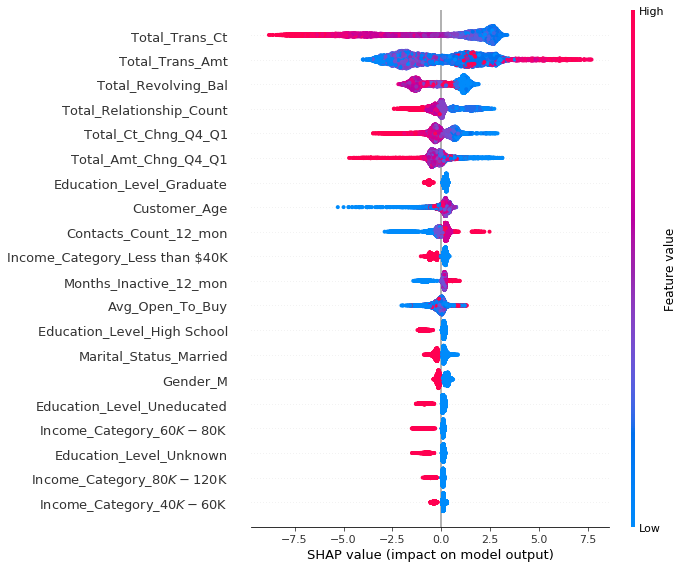

In [48]:
print("Business person: Cool! Ok, so... what else affects the output in general? \nData scientist: Total transaction count greatly impacts the outcome. In general, people who make many purchases tend to churn less. On the other hand, people who spend a lot are proner to churning. An explanation to that could be that people with high average ticket sales may cancel their credit card to cut some expenses!")

# Plot 
shap.summary_plot(shap_values, X_train_balanced)

Taking a look at how the combination of values of two features could affect the logs odd of the outcome can be really insightful as well!

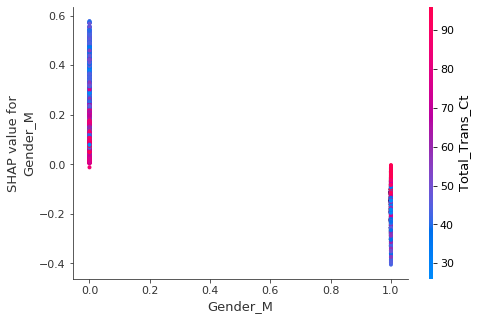

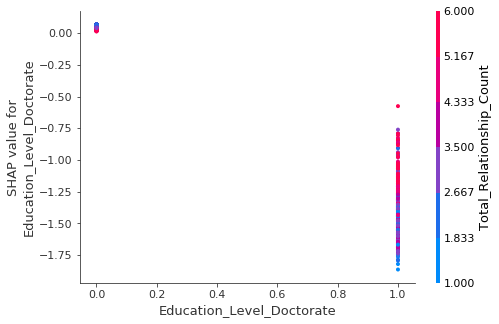

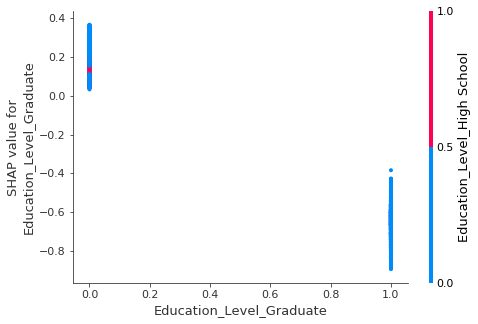

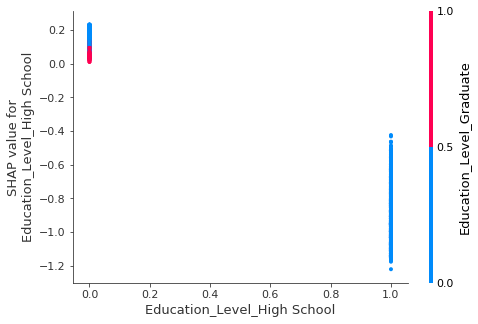

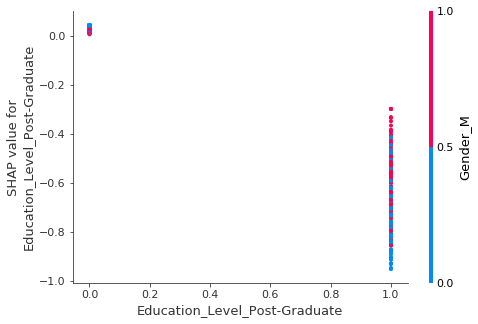

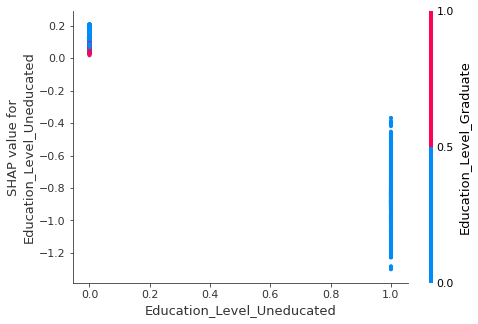

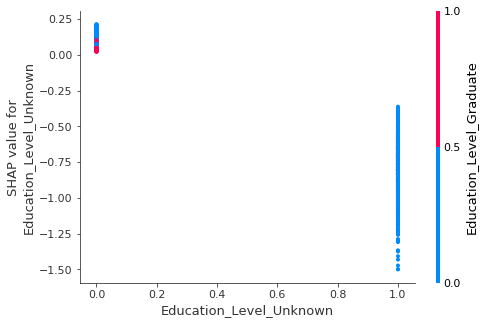

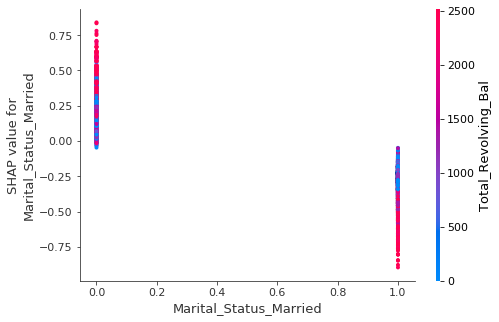

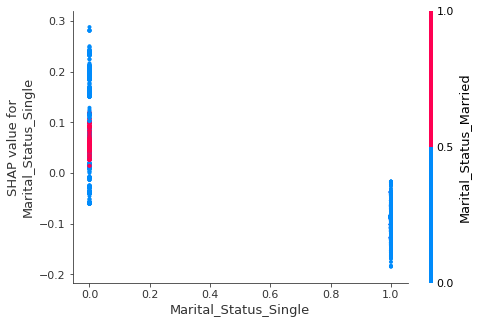

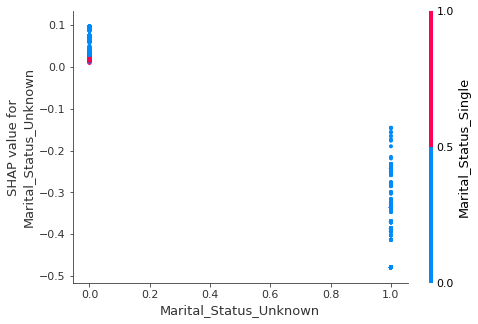

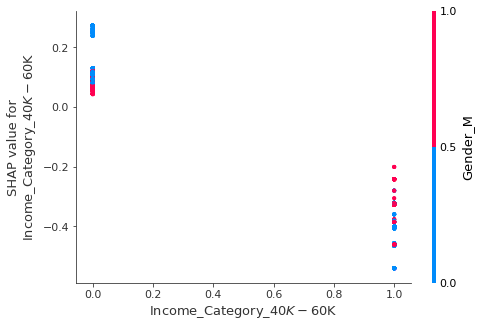

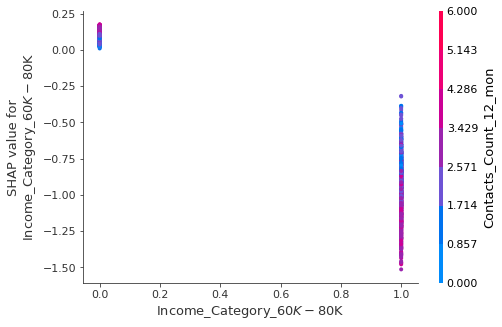

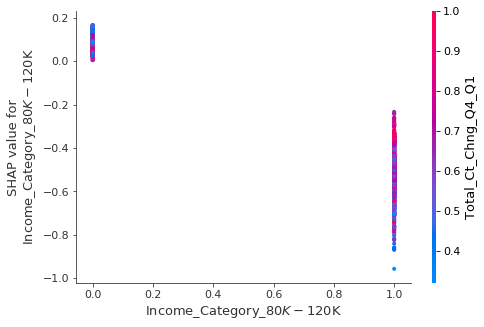

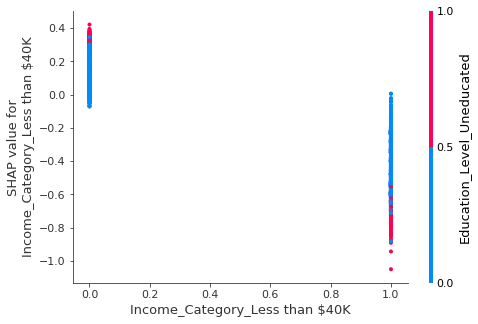

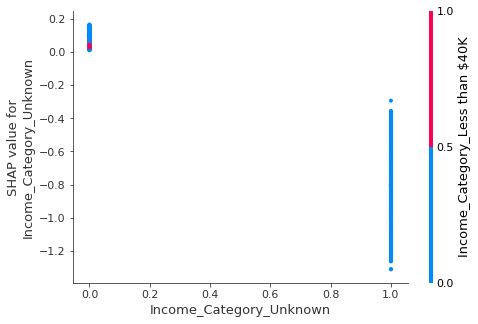

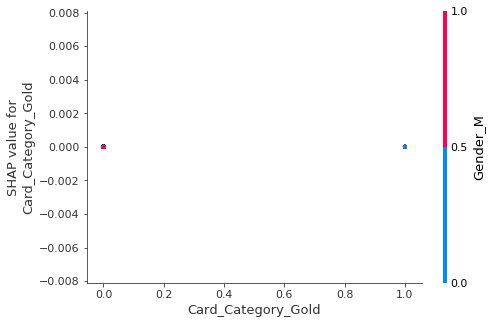

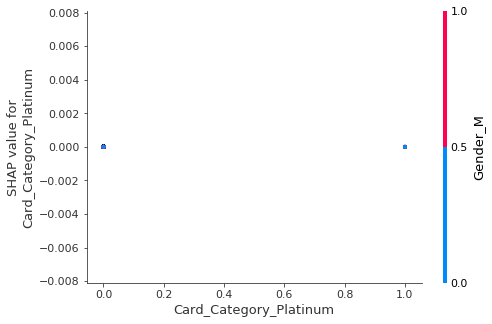

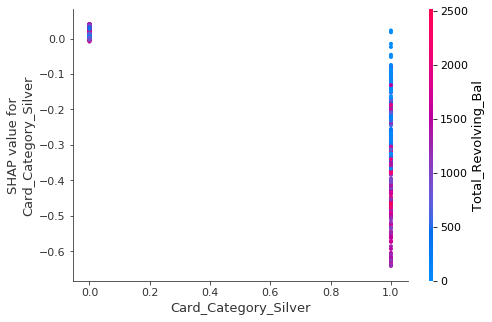

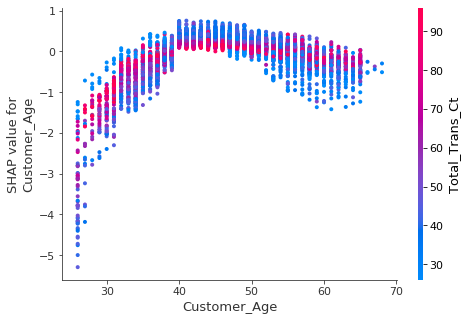

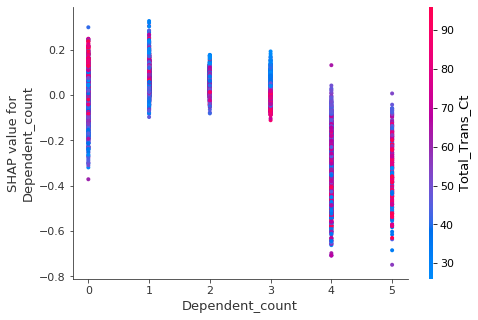

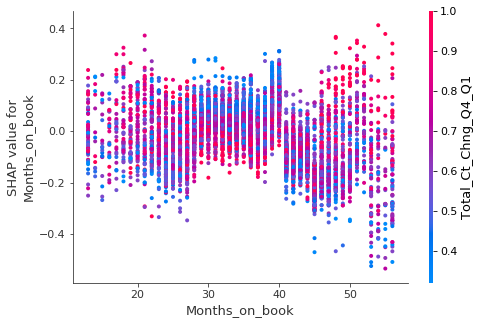

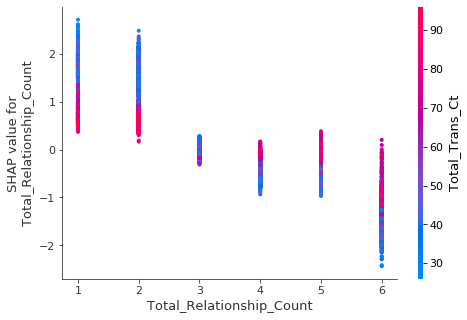

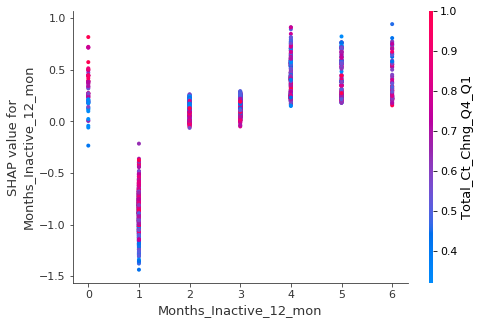

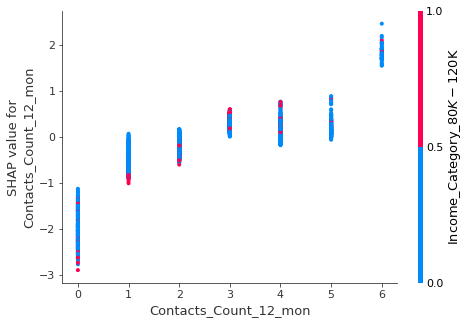

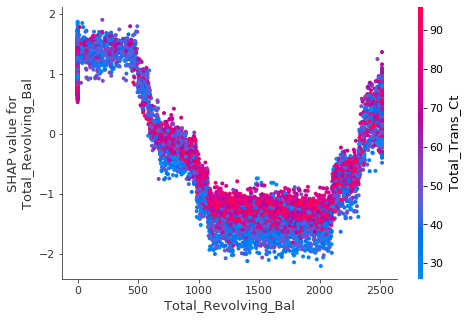

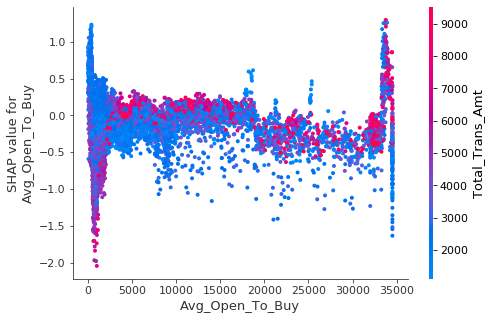

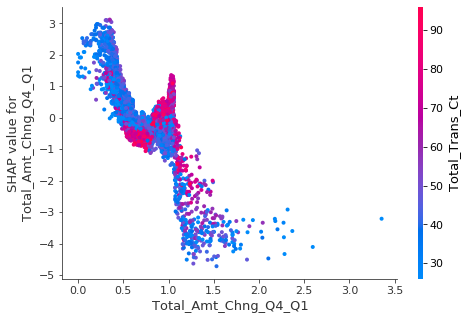

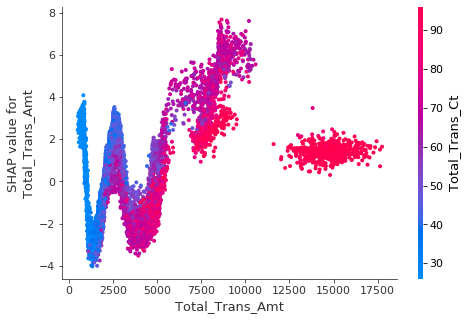

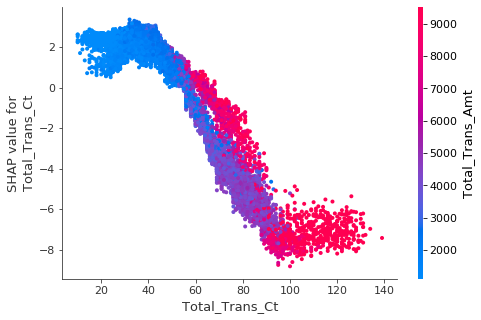

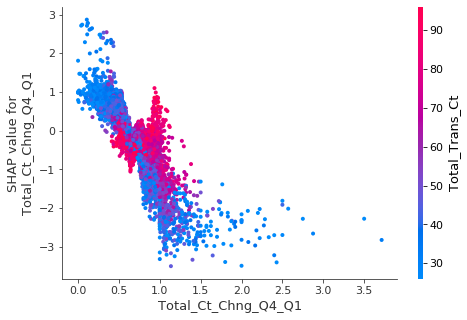

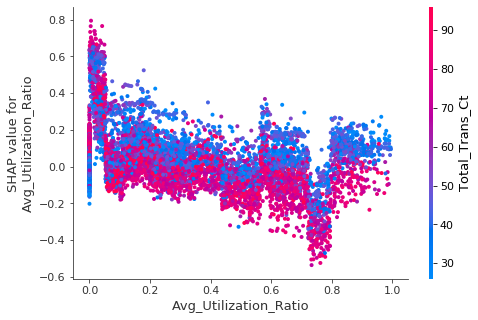

In [49]:
for var in X_train_balanced.columns:
    shap.dependence_plot(var, shap_values, X_train_balanced)